In [1]:
import os
import json
from multiprocessing import Pool

import pandas as pd
from scipy.stats import entropy
from matplotlib import pyplot as plt

from utils import (
    logging,
    TRAINING_DATA_FILE,
    DUMMY_SEQ_NAMES_FILE,
    MUTATION_SCORES_FILE,
)
from utils.miscellaneous import calculate_pred_AA


In [2]:
logging.info("Load data..")

seq_mut: pd.DataFrame = pd.read_feather(TRAINING_DATA_FILE)
mutation_scores: pd.DataFrame = pd.read_feather(MUTATION_SCORES_FILE)

with open(DUMMY_SEQ_NAMES_FILE) as f:
    dummy_seq_names = json.load(f)


In [3]:
true_AA = seq_mut.loc[~seq_mut["Accession"].isin(dummy_seq_names)]
true_AA = true_AA[["Accession", "Pos", "AA"]]
true_AA = true_AA.sort_values(["Accession", "Pos"])
true_AA = true_AA.reset_index(drop=True)

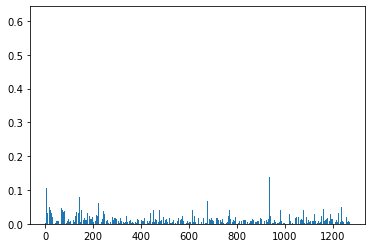

In [5]:
pos_group: pd.DataFrame

pos_entropy = [{"Pos": pos, "Entropy": entropy(pos_group["AA"].value_counts())}
               for pos, pos_group in true_AA.groupby("Pos")]
pos_entropy = pd.DataFrame.from_records(pos_entropy)

plt.bar(pos_entropy["Pos"], pos_entropy["Entropy"])
plt.savefig("plots/pos_entropy.pdf")


In [6]:
aa_table = seq_mut[["AA", "AA_idx"]].drop_duplicates()
aa_table = aa_table.set_index("AA_idx").sort_index()
aa_table = aa_table["AA"]

pred_scores = mutation_scores.loc[~mutation_scores["Accession"].isin(
    dummy_seq_names)]


In [7]:
with Pool(os.cpu_count()) as p:
    pred_AA = p.starmap(
        func=calculate_pred_AA,
        iterable=((ac, ac_group, aa_table, true_AA[true_AA["Accession"] == ac].set_index("Pos"))
                  for ac, ac_group in pred_scores.groupby("Accession", sort=False))
    )
    pred_AA = pd.concat(pred_AA)
    pred_AA = pred_AA.sort_values(["Accession", "Pos"])
    pred_AA = pred_AA.reset_index(drop=True)


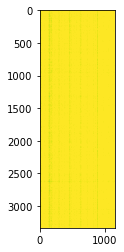

In [9]:
plt.imshow(
    pred_AA.pivot_table(index="Accession", columns="Pos",
                        values="AA", sort=False),
)
plt.savefig("plots/correct_AA_heatmap.pdf", bbox_inches="tight")

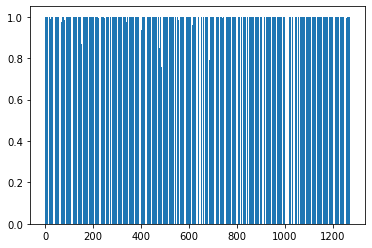

In [10]:
n_seq = pred_scores["Accession"].nunique()

correct_AA = [{"Pos": pos, "Freq": sum(pos_group["AA"]) / n_seq}
              for pos, pos_group in pred_AA.groupby("Pos")]
correct_AA = pd.DataFrame.from_records(correct_AA)

plt.bar(correct_AA["Pos"], correct_AA["Freq"])
plt.savefig("plots/correct_AA_freq.pdf")

In [12]:
sum(pred_AA["AA"]) / len(pred_AA.index)

0.995758034026465